### 数据导入

In [38]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

In [39]:
import pandas as pd
train_data = pd.read_excel('/content/drive/MyDrive/BuildModel/Molecular_Descriptor.xlsx')#,sheet_name='test')
train_label = pd.read_excel('/content/drive/MyDrive/BuildModel/ERα_activity.xlsx')#,sheet_name='test')
# 获取train_data的描述性数据
t_describe = train_data.describe()
t_describe = pd.DataFrame(t_describe.values.T, index=t_describe.columns, columns=t_describe.index)
drop_index = pd.Series(t_describe[t_describe['mean']==0.].index)
train_data = train_data.drop(drop_index,axis=1)
train_data = train_data.set_index('SMILES')
train_data.head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATSc1,ATSc2,ATSc3,ATSc4,ATSc5,ATSm1,ATSm2,ATSm3,ATSm4,ATSm5,ATSp1,ATSp2,ATSp3,ATSp4,ATSp5,nBase,BCUTw-1l,BCUTw-1h,BCUTc-1l,BCUTc-1h,...,n6Ring,n7Ring,n8Ring,n12Ring,nG12Ring,nFRing,nF6Ring,nF7Ring,nF8Ring,nF9Ring,nF10Ring,nF11Ring,nF12Ring,nFG12Ring,nTRing,nT4Ring,nT5Ring,nT6Ring,nT7Ring,nT8Ring,nT9Ring,nT10Ring,nT11Ring,nT12Ring,nTG12Ring,nRotB,LipinskiFailures,TopoPSA,VABC,VAdjMat,MW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
SMILES,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCC3)c4ccc(OCCN5CCCCC5)cc4,0,-0.2860,0.081796,126.1188,74.170169,12,12,64,31,33,26,1,3,1,0,0,0,0,0,0,0.460175,-0.217040,-0.126453,0.161524,-0.080148,39.811140,40.498576,58.166514,61.613797,58.060335,2469.977567,2930.668527,4109.492845,4128.339568,3792.779760,1,11.85,31.972073,-0.360525,0.185437,...,4,0,0,0,0,1,0,0,0,0,1,0,0,0,6,0,1,4,0,0,0,1,0,0,0,6,0,67.23,414.727478,5.954196,439.218115,64.771680,2.089409,15.471445,8.858910,3.406628,3011,47,4.666,166
Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCCCC3)c4ccc(OCCN5CCCCC5)cc4,0,-0.8620,0.743044,131.9420,80.357341,12,12,70,33,37,28,1,3,1,0,0,0,0,0,0,0.460175,-0.217040,-0.126453,0.161524,-0.080148,41.811140,42.498576,60.166514,68.613797,60.060335,2679.488262,3157.289284,4379.505354,4811.560374,4154.384741,1,11.85,31.972073,-0.360530,0.185459,...,4,1,0,0,0,1,0,0,0,0,1,0,0,0,6,0,0,4,1,0,0,1,0,0,0,6,1,67.23,449.319447,6.044394,467.249415,68.960024,2.089698,15.486947,8.863774,3.406648,3516,54,5.804,174
Oc1ccc(cc1)[C@H]2Sc3cc(O)ccc3O[C@H]2c4ccc(OCCN5CCCCC5)cc4,0,0.7296,0.532316,139.9304,74.064997,18,18,62,33,29,27,1,4,1,0,0,0,0,0,0,0.519350,-0.236031,-0.143126,0.175159,-0.059065,42.585609,42.830668,61.830698,67.277981,60.392427,2576.569862,3054.050592,4285.592752,4479.177597,3993.734054,1,11.85,31.972073,-0.361379,0.116954,...,5,0,0,0,0,1,0,0,0,0,1,0,0,0,6,0,0,5,0,0,0,1,0,0,0,6,0,87.46,422.004313,6.044394,463.181729,68.748923,2.083301,18.011114,11.390412,3.406644,3542,52,2.964,176
Oc1ccc2O[C@H]([C@@H](CC3CCCCC3)Sc2c1)c4ccc(OCCN5CCCCC5)cc4,0,-0.3184,0.101379,133.4822,80.357341,12,12,70,33,37,28,1,3,1,0,0,0,0,0,0,0.460206,-0.216970,-0.126504,0.161226,-0.079743,41.811140,42.498576,60.166514,62.944012,57.728243,2596.316352,3045.933534,4193.549346,4311.294610,3850.190106,1,11.85,31.972073,-0.360530,0.185459,...,5,0,0,0,0,1,0,0,0,0,1,0,0,0,6,0,0,5,0,0,0,1,0,0,0,7,1,67.23,449.319447,6.044394,467.249415,68.883696,2.087385,15.468365,8.857943,3.406624,3594,50,6.015,174
Oc1ccc2O[C@H]([C@@H](Cc3ccccc3)Sc2c1)c4ccc(OCCN5CCCCC5)cc4,0,1.3551,1.836296,143.1903,76.356583,18,18,64,33,31,28,1,3,1,0,0,0,0,0,0,0.462912,-0.215099,-0.128690,0.152869,-0.069664,41.811140,42.498576,60.166514,62.944012,57.728243,2561.845107,3007.231045,4144.672227,4265.064807,3806.120673,1,11.85,31.972073,-0.360530,0.185459,...,5,0,0,0,0,1,0,0,0,0,1,0,0,0,6,0,0,5,0,0,0,1,0,0,0,7,0,67.23,430.510071,6.044394,461.202465,68.883696,2.087385,15.468365,8.857943,3.406624,3594,50,4.462,174


#### 特征处理

In [45]:
#attr_labels = pd.read_excel("/content/drive/MyDrive/BuildModel/pearsonr_labels.xlsx").loc[:,0]
attr_labels = pd.read_excel("/content/drive/MyDrive/BuildModel/rf_labels.xlsx").loc[:,1]
attr_labels = list(attr_labels)
attr_labels

['MDEC-23',
 'LipoaffinityIndex',
 'minsssN',
 'maxssO',
 'maxHsOH',
 'minHsOH',
 'C1SP2',
 'BCUTc-1l',
 'MLogP',
 'VC-5',
 'MLFER_A',
 'nHBAcc',
 'minsOH',
 'minHBint5',
 'MDEC-33',
 'TopoPSA',
 'ATSc3',
 'hmin',
 'SHsOH',
 'ATSc2']

In [46]:
# 特征选择
#t_data = train_data
t_data = train_data.loc[:,attr_labels]
print(t_data.head())
t_label = train_label.iloc[:,2]
print(t_label.head())
# 标准化
# std_scaler = StandardScaler().fit(t_data)
# t_scaledata = std_scaler.transform(t_data)

# 0-1区间缩放
mm_scaler = MinMaxScaler().fit(t_data)
t_scaledata = mm_scaler.transform(t_data)

                                                      MDEC-23  ...     ATSc2
SMILES                                                         ...          
Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCC3)c4ccc(OCCN5CC...  28.277932  ... -0.217040
Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCCCC3)c4ccc(OCCN5...  31.076748  ... -0.217040
Oc1ccc(cc1)[C@H]2Sc3cc(O)ccc3O[C@H]2c4ccc(OCCN5...  30.901064  ... -0.236031
Oc1ccc2O[C@H]([C@@H](CC3CCCCC3)Sc2c1)c4ccc(OCCN...  30.570001  ... -0.216970
Oc1ccc2O[C@H]([C@@H](Cc3ccccc3)Sc2c1)c4ccc(OCCN...  30.570001  ... -0.215099

[5 rows x 20 columns]
0    8.602060
1    8.124939
2    8.508638
3    8.408935
4    8.130768
Name: pIC50, dtype: float64


#### 设置训练数据集

In [48]:

X_train, X_test, y_train, y_test = train_test_split(t_scaledata, t_label, test_size=0.2,shuffle=False)

### 数据预处理

In [37]:
y_train

0       8.602060
1       8.124939
2       8.508638
3       8.408935
4       8.130768
          ...   
1574    7.330033
1575    5.879999
1576    7.519993
1577    7.360016
1578    6.109998
Name: pIC50, Length: 1579, dtype: float64

### 模型建立

#### 评分函数

In [8]:
from sklearn.metrics import make_scorer
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)
def mse(y_ture,y_pred):
    return mean_squared_error(y_ture,y_pred)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)
mse_scorer = make_scorer(mse, greater_is_better=False)

#### 网格训练模型

In [18]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
def train_model(model, param_grid=[], X=[], y=[], splits=5, repeats=5):

    # 创建交叉验证
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)

    # 判断是否进行网格搜索
    if len(param_grid) > 0:

        gsearch = GridSearchCV(model, param_grid, cv=rkfold, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1, return_train_score=True)
        gsearch.fit(X, y)
        # print("打印所有模型结果")
        # print(gsearch.cv_results_['mean_test_score'])

        # 提取最好的模型
        model = gsearch.best_estimator_
        best_idx = gsearch.best_index_

        # 获取cv-scores
        grid_results = pd.DataFrame(gsearch.cv_results_)
        cv_mean = abs(grid_results.loc[best_idx, 'mean_test_score'])
        cv_std = grid_results.loc[best_idx, 'std_test_score']

    # 无需网格搜索
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)

    # 获取各部分结果的均值和标准差
    cv_score = pd.Series({'mean': cv_mean, 'std': cv_std})

    # 预测
    y_pred = model.predict(X)

    # 打印模型performance
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=', model.score(X, y))
    print('rmse=', rmse(y, y_pred))
    print('mse=', mse(y, y_pred))
    print('cross_val: mean=', cv_mean, ', std=', cv_std)

    # 绘制残差
    y_pred = pd.Series(y_pred, index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid) / std_resid
    n_outliers = sum(abs(z) > 3)

    plt.figure(figsize=(15, 5))
    ax_131 = plt.subplot(1, 3, 1)
    plt.plot(y, y_pred, '.')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    plt.title('corr = {:.3f}'.format(np.corrcoef(y, y_pred)[0][1]))
    ax_132 = plt.subplot(1, 3, 2)
    plt.plot(y, y - y_pred, '.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred')
    plt.title('std resid = {:.3f}'.format(std_resid))

    ax_133 = plt.subplot(1, 3, 3)
    z.plot.hist(bins=50, ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

In [10]:
# 存储模型和模型的scores
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])
# k-fold splits
splits=5
# k-fold iterations
repeats=1

In [ ]:
def print_loss(reg_model):
  from sklearn.metrics import mean_squared_error
  print("The mean_squred_error of train:",mean_squared_error(y_test, reg_model.predict(X_test)))
  print("The mean_squred_error of test:",mean_squared_error(y_test, reg_model.predict(X_test)))
  print('The R^2 of train:', reg_model.score(X_train, y_train))
  print('The R^2 of test:', reg_model.score(X_test, y_test))

#### 单一模型预测

##### 岭回归

Fitting 5 folds for each of 23 candidates, totalling 115 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.4s finished


----------------------
Ridge(alpha=0.25, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------
score= 0.5565466291780143
rmse= 0.9465838835750175
mse= 0.8960210486439611
cross_val: mean= 0.9243636984003443 , std= 0.06193584278081752


Text(0, 0.5, 'score')

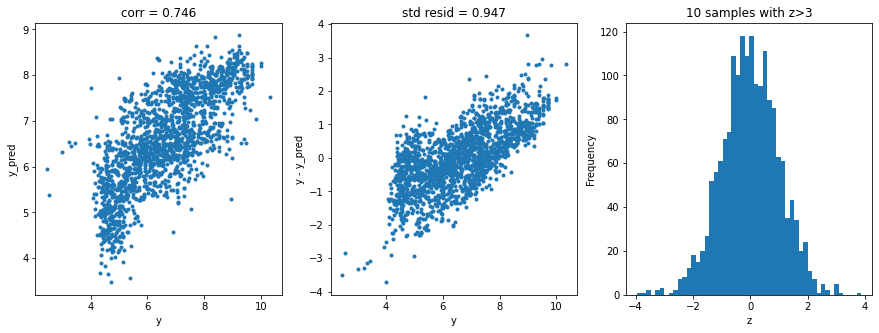

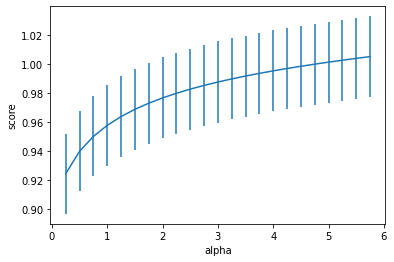

In [11]:
model = 'Ridge'

opt_models[model] = Ridge()
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models[model],cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, X=X_train, y = y_train, splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']), abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

##### LASSO回归

Fitting 5 folds for each of 23 candidates, totalling 115 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    1.3s finished


----------------------
Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.5658070230493075
rmse= 0.9366482433763709
mse= 0.8773099318200391
cross_val: mean= 0.9076113098699088 , std= 0.09053941182075083


Text(0, 0.5, 'score')

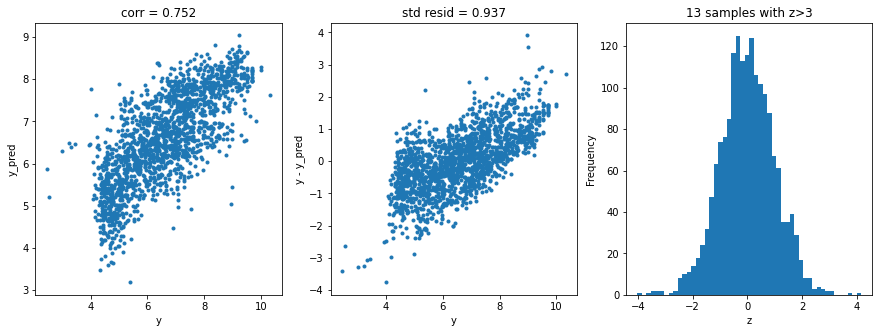

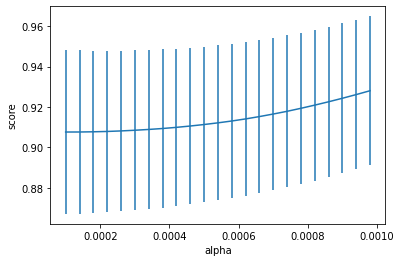

In [12]:
model = 'Lasso'

opt_models[model] = Lasso()
alph_range = np.arange(1e-4, 1e-3, 4e-5)
param_grid = {'alpha': alph_range}
opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, X=X_train, y = y_train, splits=splits, repeats=repeats)


cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(
    alph_range, abs(grid_results['mean_test_score']),
    abs(grid_results['std_test_score']) / np.sqrt(splits * repeats))
plt.xlabel('alpha')
plt.ylabel('score')

##### ElasticNet 回归

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:    3.9s finished


----------------------
ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=100000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.5654064463139103
rmse= 0.9370802091354775
mse= 0.8781193183533912
cross_val: mean= 0.9080091725086952 , std= 0.06294094144619516


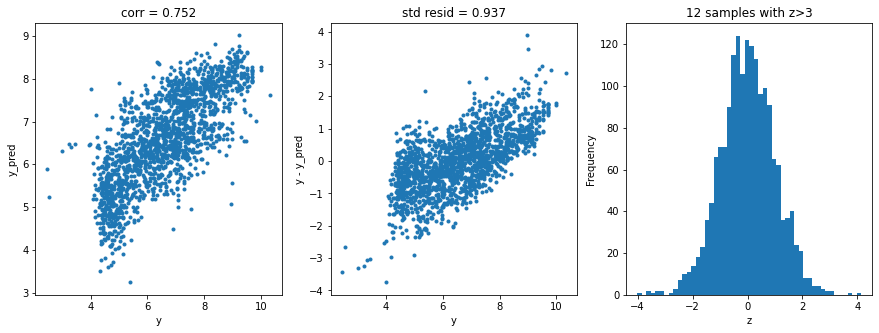

In [13]:
model = 'ElasticNet'
opt_models[model] = ElasticNet()

param_grid = {
    'alpha': np.arange(1e-4, 1e-3, 1e-4),
    'l1_ratio': np.arange(0.1, 1.0, 0.1),
    'max_iter': [100000]
}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, X=X_train, y = y_train, splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

##### SVR回归

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.m

----------------------
SVR(C=0.9, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=1000, shrinking=True, tol=0.001, verbose=False)
----------------------
score= 0.6370578133009279
rmse= 0.8563550269829685
mse= 0.7333439322390014
cross_val: mean= 0.7938334202949087 , std= 0.05653200893079111


Text(0, 0.5, 'score')

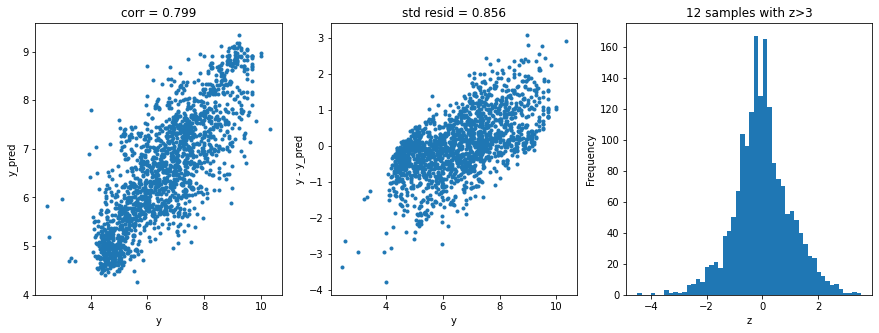

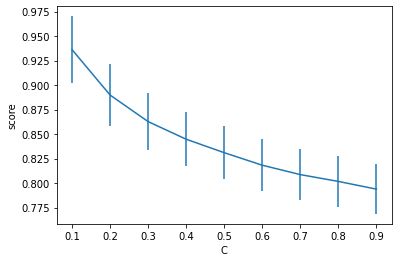

In [14]:
model = 'SVR'
opt_models[model] = SVR()

crange = np.arange(0.1, 1.0, 0.1)
param_grid = {'C': crange, 'max_iter': [1000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, X=X_train, y = y_train, splits=splits, repeats=repeats)
cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(
    crange, 
    abs(grid_results['mean_test_score']),
    abs(grid_results['std_test_score']) / np.sqrt(splits * repeats))
plt.xlabel('C')
plt.ylabel('score')

##### K最近邻

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.1s finished


----------------------
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
----------------------
score= 0.8096212976755522
rmse= 0.6202179152159608
mse= 0.3846702623548328
cross_val: mean= 0.6351261517560874 , std= 0.0417887224086718


Text(0, 0.5, 'score')

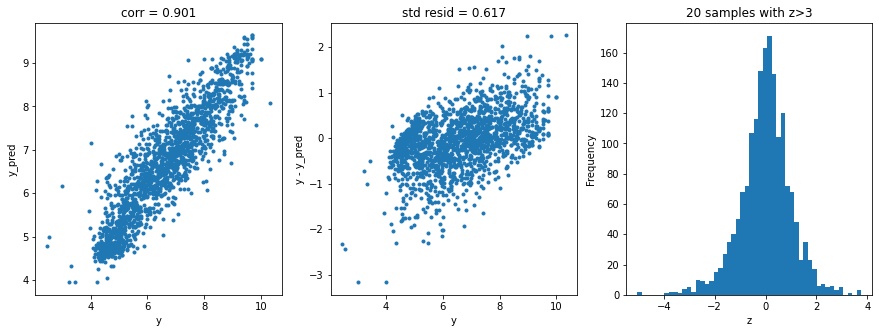

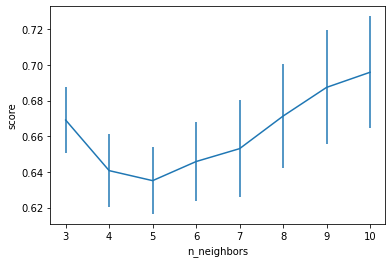

In [15]:
model = 'KNeighbors'
opt_models[model] = KNeighborsRegressor()

param_grid = {'n_neighbors': np.arange(3, 11, 1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, X=X_train, y = y_train, splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(
    np.arange(3, 11, 1), 
    abs(grid_results['mean_test_score']),
    abs(grid_results['std_test_score']) / np.sqrt(splits * 1))
plt.xlabel('n_neighbors')
plt.ylabel('score')

#### 模型融合Boosting

##### GBDT模型

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished


----------------------
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
----------------------
score= 0.9756795919376524
rmse= 0.22167695868735451
mse= 0.04914067401287501
cross_val: mean= 0.5270890855979072 , std= 0.05699449531648258


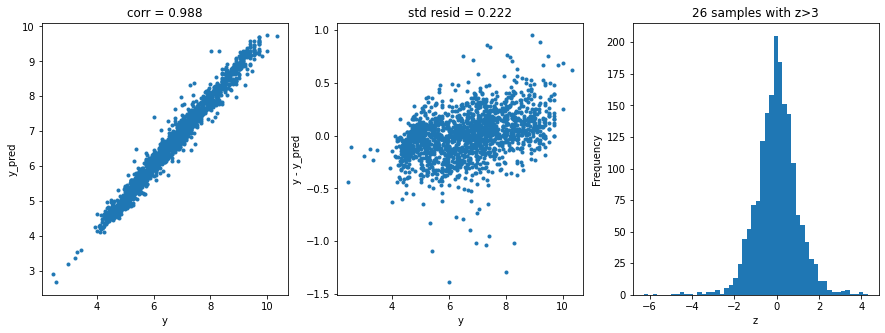

In [20]:
model = 'GradientBoosting'
opt_models[model] = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 7, 9, 11, 13],
}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, X=X_train, y = y_train, splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

##### XGB模型

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


----------------------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
----------------------
score= 0.9520230922957621
rmse= 0.3113517076559781
mse= 0.09693988586029365
cross_val: mean= 0.5402930487524957 , std= 0.03615181881252263


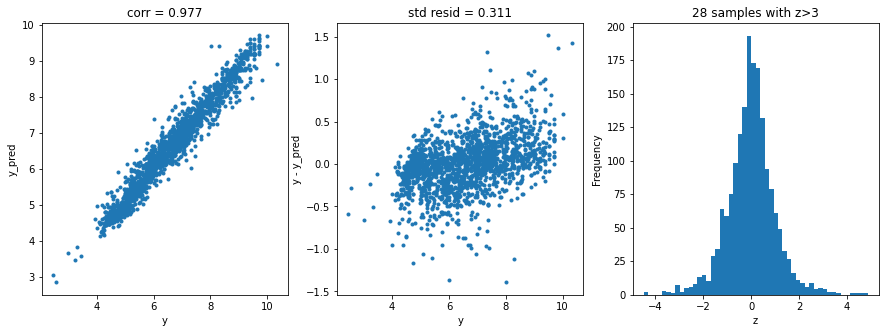

In [24]:
model = 'XGB'
#opt_models[model] = XGBRegressor()
opt_models[model] = XGBRegressor(objective='reg:squarederror')
param_grid = {
    'n_estimators': [150, 200, 250, 300],
    'max_depth': [4, 5, 6],
}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, X=X_train, y = y_train, splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

##### 随机森林模型

In [ ]:
opt_models['RandomForest'].score(X_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.1min finished


----------------------
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=13, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
----------------------
score= 0.9545256010791704
rmse= 0.3007097056034766
mse= 0.09042632704412937
cross_val: mean= 0.49946054527883926 , std= 0.024869050045460986


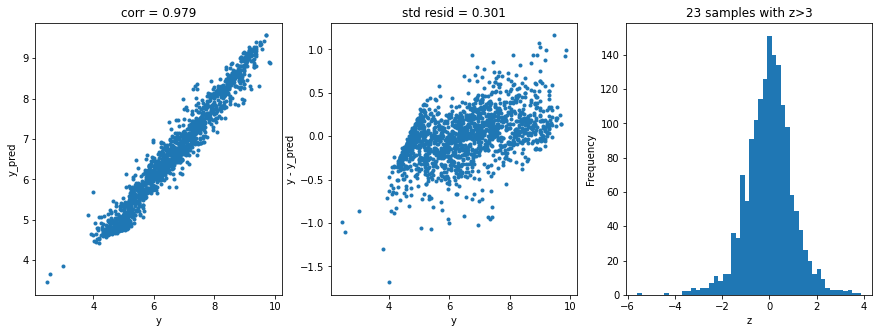

In [49]:
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {
    'n_estimators': [200,300,400],
    'max_depth':[11, 13, 15],
}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, X=X_train, y = y_train, splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

##### Adaboosting

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   54.3s finished


----------------------
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=10,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='be

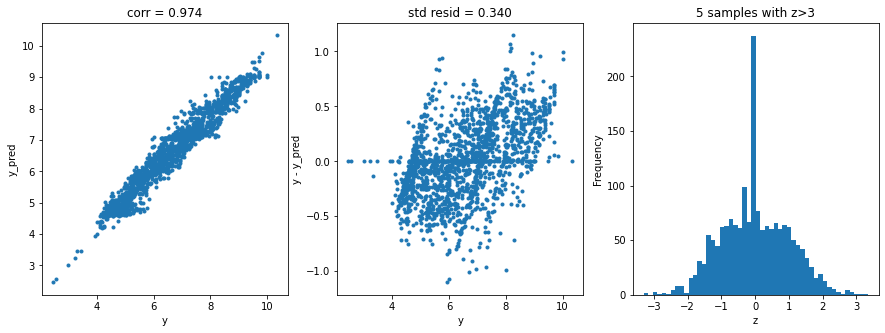

In [28]:
model = 'AdaBoostRegressor'
opt_models[model] = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10))

param_grid = {
    'n_estimators': [200, 400, 600, 800],
}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, X=X_train, y = y_train, splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

#### 多模型预测Bagging方法

In [29]:
def model_predict(test_data,test_y=[],stack=False):

    i=0
    y_predict_total=np.zeros((test_data.shape[0],))
    for model in opt_models.keys():
        if model in ["XGB", "KNeighbors","GradientBoosting","RandomForest","AdaBoostRegressor"]:
            y_predict=opt_models[model].predict(test_data)
            y_predict_total+=y_predict
            i+=1
            print("{}_score:".format(model),opt_models[model].score(X_test,y_test))
            print("{}_mse:".format(model),mean_squared_error(y_predict,test_y))
    y_predict_mean=np.round(y_predict_total/i,3)
    if len(test_y)>0:
        print("mean_mse:",mean_squared_error(y_predict_mean,test_y))
    else:
        y_predict_mean=pd.Series(y_predict_mean)
        return y_predict_mean

In [32]:
model_predict(X_test,y_test)

KNeighbors_score: 0.6712983385443642
KNeighbors_mse: 0.6738141673314011
GradientBoosting_score: 0.7310169082459497
GradientBoosting_mse: 0.551395503125388
XGB_score: 0.7133018595602969
XGB_mse: 0.5877100466129311
RandomForest_score: 0.7232374283073977
RandomForest_mse: 0.5673428633360218
AdaBoostRegressor_score: 0.7554409943399398
AdaBoostRegressor_mse: 0.5013279276790934
mean_mse: 0.5287404617014022


In [ ]:
def grid_search(model, param_grid):
  from sklearn.model_selection import GridSearchCV

  forest_reg = model

  grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error")
  grid_search.fit(X_train, y_train)
  return grid_search.best_params_

#### 投票法

In [25]:
from sklearn.ensemble import VotingRegressor

models = [(m,opt_models[m]) for m in opt_models.keys() if m in ["XGB", "KNeighbors","GradientBoosting","RandomForest","AdaBoostRegressor"]]
vot_regr = VotingRegressor(models).fit(X_train, y_train)
print("mean_squred_error:",mean_squared_error(y_test, vot_regr.predict(X_test)))
print('train R^2:', vot_regr.score(X_train, y_train))
print('test R^2:', vot_regr.score(X_test, y_test))

mean_squred_error: 0.5369004742902944
train R^2: 0.9488061801117182
test R^2: 0.7380879083702307


#### 保存优秀的模型

In [33]:
from joblib import dump, load
dump(opt_models['AdaBoostRegressor'], '/content/drive/MyDrive/BuildModel/question_2.joblib')
#clf = load('filename.joblib') 

['/content/drive/MyDrive/BuildModel/question_2.joblib']

In [35]:
reg = load('/content/drive/MyDrive/BuildModel/question_2.joblib')
reg.score(X_test,y_test)

0.7554409943399398

### 筛选最有影响力的属性

#### 相关系数

In [ ]:
data = pd.merge(train_data, train_label, how='left', on = 'SMILES')
corr_matrix = data.corr()
k = 21
cols = corr_matrix.nlargest(k,'pIC50')['pIC50'].index
pd.Series(cols)[1:].to_excel('/content/drive/MyDrive/BuildModel/pearson_labels.xlsx')
# attr_labels = list(pd.Series(cols))[1:]
# attr_labels

In [ ]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr


select_kbest = SelectKBest(lambda X, Y:np.array(list(map(lambda x:pearsonr(x,Y), X.T))).T[0],k=20).fit(t_scaledata, t_label)
select_kbest

SelectKBest(k=20, score_func=<function <lambda> at 0x7f890f2b98c0>)

In [ ]:
attr_names = pd.Series(train_data.columns)
attr_labels = attr_names[select_kbest.get_support()]
pd.Series(attr_labels).to_excel("/content/drive/MyDrive/BuildModel/pearsonr_labels.xlsx")

#### 最大信息系数法

In [ ]:
!pip install minepy

     |████████████████████████████████| 495 kB 27.4 MB/s 
  Created wheel for minepy: filename=minepy-1.2.5-cp37-cp37m-linux_x86_64.whl size=177542 sha256=c609478e896ef2771954e6c29eee874634b116863ace15932506ddd22f70d8a3
  Stored in directory: /root/.cache/pip/wheels/d1/ea/d7/fabbfa6e294adcbc43dabca0e0158dafdd36051246992c7311
Successfully built minepy


In [ ]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from minepy import MINE

def mic(x,y):
  m = MINE()
  m.compute_score(x, y)

  return (m.mic(), 0.5)

select_kbest = SelectKBest(lambda X, Y:np.array(list(map(lambda x:mic(x,Y), X.T))).T[0],k=20).fit(t_scaledata, t_label)
select_kbest


SelectKBest(k=20, score_func=<function <lambda> at 0x7f890ce9a440>)

In [ ]:
attr_names = pd.Series(train_data.columns)
attr_labels = attr_names[select_kbest.get_support()]


In [ ]:
pd.Series(attr_labels).to_excel("/content/drive/MyDrive/BuildModel/maxinfo_labels.xlsx")

#### 基于树模型的特征选择方法

In [ ]:
attr_names = pd.Series(t_data.columns)


In [ ]:
feature_importances = rf_regr.feature_importances_
result = sorted(zip(feature_importances, attr_names),reverse=True)
result = pd.DataFrame(result[:20]).loc[:,1]
result.to_excel('/content/drive/MyDrive/BuildModel/rf_labels.xlsx')


In [ ]:
result.to_excel(/content/drive/MyDrive/BuildModel/rf_labels.xlsx')

In [ ]:
ls

drive/  result.xls  sample_data/


### 模型测试




In [ ]:
print("label:",t_label[:10])
test_data = scaler.transform(t_data[:10])
regr.predict(test_data)

label: 0    8.602060
1    8.124939
2    8.508638
3    8.408935
4    8.130768
5    6.309804
6    9.000000
7    7.455932
8    8.366532
9    7.040959
Name: pIC50, dtype: float64


array([8.87869975, 8.61659097, 8.44433438, 8.03326314, 8.3759704 ,
       7.80219894, 7.96593717, 7.71571667, 7.50751798, 6.94109699])